<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error,mean_squared_error,make_scorer
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,5)
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import  make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [2]:
data=pd.read_csv('/datasets/taxi.csv')

In [3]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Изучим наш дата фрейм

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Изменим тип данных datetime с object на datetime64

In [5]:
data['datetime']=pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим в хронологическом ли порядке расположены даты и время

In [8]:
print(data.index.is_monotonic)

True


In [9]:
data.isnull().sum()

num_orders    0
dtype: int64

Отсутсвующих данных нет

In [10]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Предобработку выполнили, аномалий не найдено можем перейти к ресемплированию данных

Text(0.5, 1.0, 'data_resample')

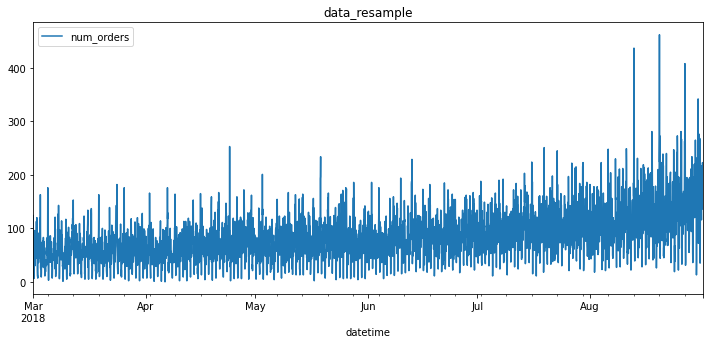

In [11]:
data = data.resample('1h').sum()
data.plot()
plt.title('data_resample')

**Вывод**

Выполнили предобратку. Изменили тип данных datetime с object на datetime64, проверили на хронологическое расположение данных.

Выполнили ресемплирование данных по одному часу

## Анализ

Посмотрим тренды и сезонность

In [12]:
decomposed =seasonal_decompose(data)

Text(0.5, 1.0, 'Trend')

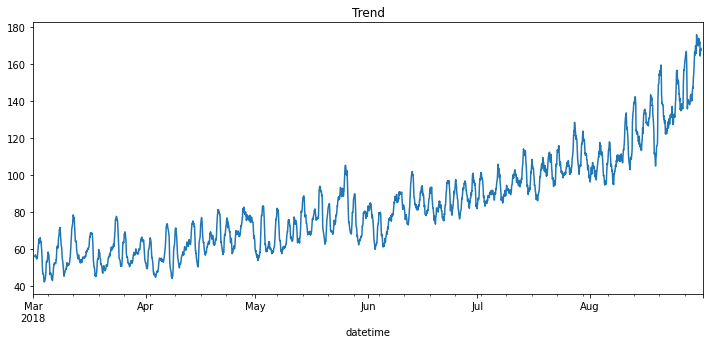

In [13]:
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

Text(0.5, 1.0, 'Seasonality')

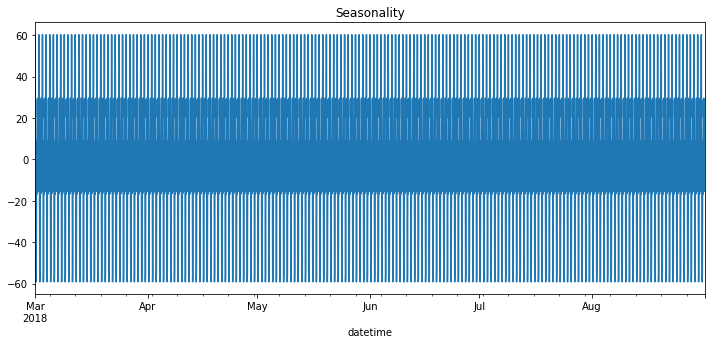

In [14]:
decomposed.seasonal.plot()
plt.title('Seasonality')

Text(0.5, 1.0, 'Residuals')

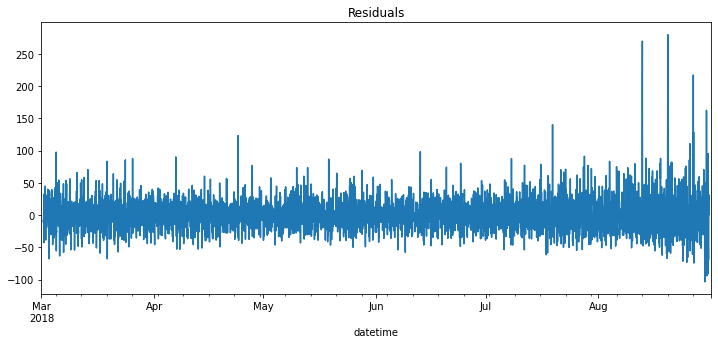

In [15]:
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

Очень сложно оценить сезонность, возьму данные за меньший промежуток времени

Text(0.5, 1.0, 'Seasonality')

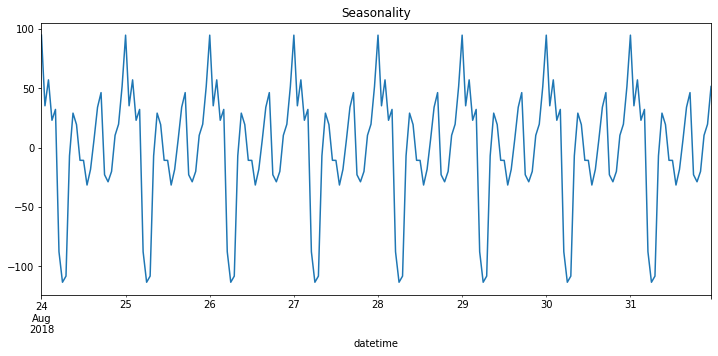

In [16]:
decomposed = seasonal_decompose(data['2018-08-24':'2018-08-31'])
decomposed.seasonal.plot()
plt.title('Seasonality')

**Вывод**

Видим восходящий тренд, потребность в такси становится увеличивается. Заметим, что ночью количесвто заказов уменьшается

## Обучение

Будем обучать модели 

DecisionTreeRegressor

LinearRegression



In [17]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(data, 40, 20)
data_train, data_test = train_test_split(data, shuffle=False, test_size=0.1)
data_train = data_train.dropna()

features_train = data_train.drop(['num_orders'], axis=1)
target_train = data_train['num_orders']
features_test = data_test.drop(['num_orders'], axis=1)
target_test = data_test['num_orders']

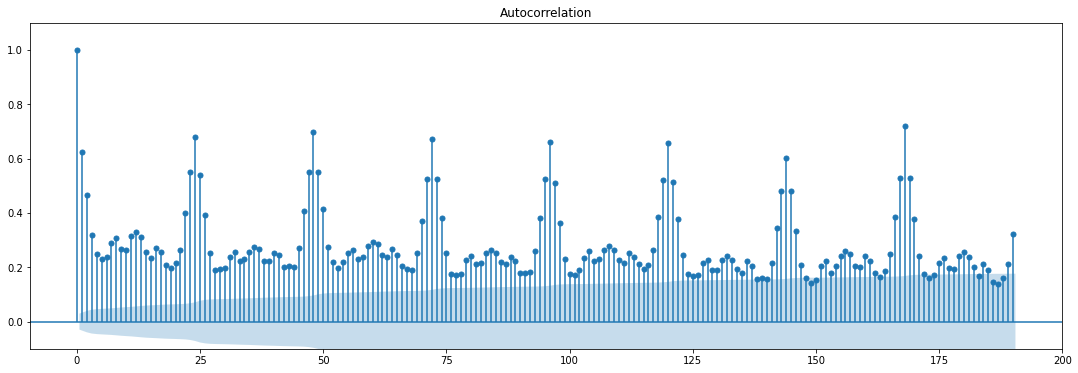

In [18]:
# Код ревьюера
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 


In [19]:
tscv = TimeSeriesSplit(n_splits=5)
model_lr = Pipeline([('scaler', MinMaxScaler()),('regressor', LinearRegression())])  
parameters_lr = {'regressor__fit_intercept':[True,False], 'regressor__normalize':[True,False], 'regressor__copy_X':[True, False]}
grid_search_lr = GridSearchCV(model_lr, cv=tscv, param_grid=parameters_lr, scoring='neg_root_mean_squared_error')
grid_search_lr.fit(features_train,target_train)
print("Лучшие гиперпараметры для LinearRegression: ", grid_search_lr.best_params_)
print("Лучшее значение метрики для LinearRegression: ", -(grid_search_lr.best_score_))

Лучшие гиперпараметры для LinearRegression:  {'regressor__copy_X': True, 'regressor__fit_intercept': True, 'regressor__normalize': False}
Лучшее значение метрики для LinearRegression:  27.17482634479679


In [20]:
model_dtr = Pipeline([('scaler', MinMaxScaler()),('regressor', DecisionTreeRegressor(random_state=12345))])
parameters_dtr = {'regressor__max_depth':range(1,10)}
grid_search_dtr = GridSearchCV(model_dtr, param_grid=parameters_dtr,  scoring='neg_root_mean_squared_error',cv=tscv)
grid_search_dtr.fit(features_train,target_train)
print("Лучшие гиперпараметры для DecisionTreeRegressor: ", grid_search_dtr.best_params_)
print("Лучшее значение метрики для DecisionTreeRegressor: ", -(grid_search_dtr.best_score_))

Лучшие гиперпараметры для DecisionTreeRegressor:  {'regressor__max_depth': 5}
Лучшее значение метрики для DecisionTreeRegressor:  30.608792129386796


На тренировочной выборке лучший результат показала модель LinearRegression, так что выберём именно её

## Тестирование

In [21]:
model_lr=LinearRegression(fit_intercept=True, copy_X=True, normalize=False )
model_lr.fit(features_train,target_train)
prediction=model_lr.predict(features_test)
print("rmse :", mean_squared_error(target_test,prediction)**.5)

rmse : 44.70524467180113


Проверим модель на адекватность

In [22]:
dummy = DummyRegressor(strategy='constant', constant=target_train.iloc[-1])
dummy.fit(features_train, target_train)
predictions = dummy.predict(features_test)
print("rmse :", mean_squared_error(target_test, predictions)**.5)

rmse : 62.05343632125475


Получили что константная модель имеет значение rmse хуже, значит наша модель адекватна и эффективна

# Вывод

В ходе работы выполнили предобработку данных:

1) Изменили тип данных datetime с object на datetime64

2) проверили на хронологическое расположение данных.

3) Выполнили ресемплирование данных по одному часу

Затем обучили модели LinearRegressionr и DecisionTreeRegressor, на обучающей выборке выборке лучший результат был у LinearRegression, поэтому выбрали ее

На тестовой выборке модель LinearRegression показала результат 44.7 , что удовлетворяет условиям. Также модель прошла проверку на адекватность, поэтому можем запускать ее в производство

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48